In [5]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

[*********************100%***********************]  1 of 1 completed


1081 combinations tested


Price,Adj Close,Close,High,Low,Open,Volume,48_ma,49_ma,Strategy,Asset_Returns,Strategy_Returns
1,1.208897,1.208897,1.210903,1.194600,1.196101,0,1.202829,1.202826,-1.0,0.010360,-0.010360
2,1.212298,1.212298,1.213003,1.207700,1.209000,0,1.206117,1.206113,1.0,0.013202,-0.007577
3,1.208094,1.208094,1.214403,1.204398,1.212004,0,1.206643,1.206639,1.0,0.009689,-0.011018
4,1.218695,1.218695,1.219096,1.206593,1.207802,0,1.209258,1.209251,1.0,0.018549,-0.002340
5,1.222001,1.222001,1.224005,1.215407,1.216797,0,1.211609,1.211598,1.0,0.021312,0.000367
...,...,...,...,...,...,...,...,...,...,...,...
5639,1.161845,1.161845,1.166453,1.160254,1.161845,0,1.160534,1.160277,1.0,-0.028965,0.228829
5640,1.163941,1.163941,1.164280,1.157474,1.163941,0,1.160673,1.160424,1.0,-0.027213,0.231046
5641,1.164795,1.164795,1.168770,1.162953,1.164795,0,1.160841,1.160599,1.0,-0.026499,0.231949
5642,1.168156,1.168156,1.170741,1.165433,1.168156,0,1.161140,1.160901,1.0,-0.023690,0.235504


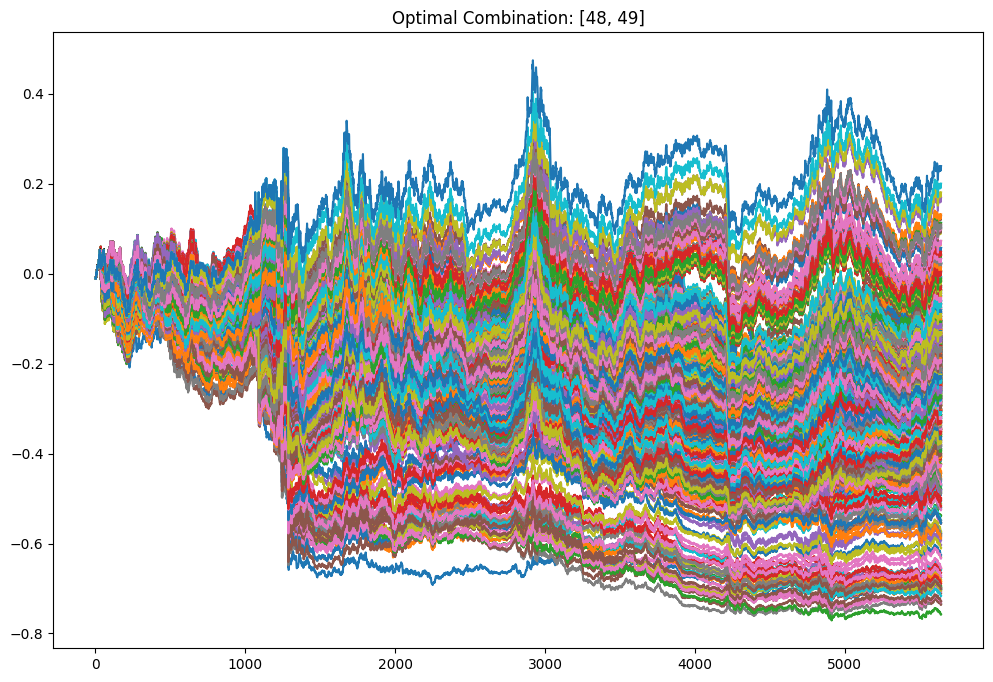

In [6]:
TICKER = 'EURUSD=X'
INTERVAL='1d'

# set period based on interval
if INTERVAL == '1h':
    PERIOD = '730d'
else:
    PERIOD = 'max'
LOOKBACK = 10000

FAST = list(range(3, 50))
SLOW = list(range(4, 50))

def get_data(ticker=TICKER, lookback=LOOKBACK, interval=INTERVAL):

    # get data at interval you want
    df = yf.download(ticker, interval=interval, auto_adjust=False)
    df.columns = df.columns.get_level_values(0)

    # reset the index to make plots prettier
    df = df.reset_index(drop=True)

    # only return the subset of data you are interested in
    return df.iloc[-lookback:, :]

def add_moving_averages(df, fast, slow):
    df[f'{fast}_ma'] = df['Close'].ewm(span=fast).mean()
    df[f'{slow}_ma'] = df['Close'].ewm(span=slow).mean()

    return df.dropna()

def add_strategy(df, fast, slow):
    
    # long when fast > slow, short otherwise
    df['Strategy'] = np.where(df[f'{fast}_ma'] > df[f'{slow}_ma'], 1, -1)
    df['Strategy'] = df['Strategy'].shift(1)
    return df

def test_strategy(df):
    df['Asset_Returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['Strategy_Returns'] = (1 + df['Close'].pct_change() * df['Strategy']).cumprod() -1

    plt.plot(df['Strategy_Returns'])    
    return df.dropna()

def main():
    base = get_data()
    plt.figure(figsize=(12, 8))
    legend_list = []

    best_returns = -np.inf
    best_params = None

    count = 0
    for s in SLOW:
        for f in FAST:
            if f < s:
                df = base.copy()
                df = add_moving_averages(df, f, s)
                df = add_strategy(df, f, s)
                df = test_strategy(df)
                legend_list.append(f'{f}, {s} cross')

                returns = float(df['Strategy_Returns'].iloc[-1])
                if returns > best_returns:
                    best_returns = returns
                    best_params = [f, s]
                
                count += 1

    plt.title(f'Optimal Combination: {best_params}')
    print(f'{count} combinations tested')
    return df

main()